# 1. 데이터 불러오기 및 라이브러리 설치

In [ ]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

#라이브러리 설치
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import anderson
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

train=pd.read_csv('/content/drive/MyDrive/train.csv', encoding = 'utf-8')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. EDA

  ## a. target 변수 분포 시각화

target 변수를 기준으로 데이터가 균형있게 분포하는 경향을 띠는 balanced data라고 판단함

In [ ]:
train['target'].value_counts()

1    24621
0    24531
Name: target, dtype: int64

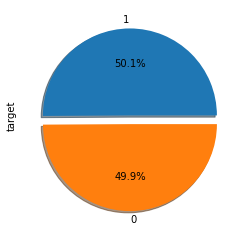

In [ ]:
train['target'].value_counts().plot.pie( 
    explode=[0,0.1],autopct='%1.1f%%',shadow=True)

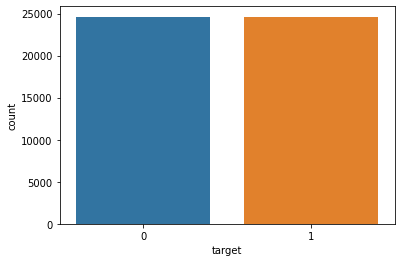

In [ ]:
sns.countplot('target', 
              data=train)
plt.show()

## b. column별 NA값 시각화

In [ ]:
train.isna().sum().value_counts()

0    257
dtype: int64

In [ ]:
na=pd.DataFrame([100,0], index=pd.Index(['notNA','NA']))
na.columns=['percent']
na

,percent
notNA,100
NA,0


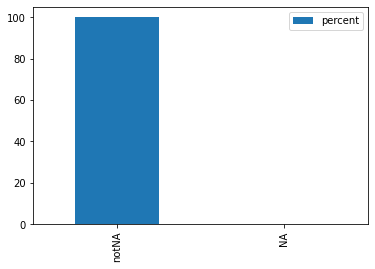

In [ ]:
na.plot.bar()
plt.show()

## c. column별 중복값 시각화

In [ ]:
train.duplicated().value_counts()

False    49152
dtype: int64

In [ ]:
dup=pd.DataFrame([100,0], index=pd.Index(['not duplicted','duplicated']))
dup.columns=['percent']
dup

,percent
not duplicted,100
duplicated,0


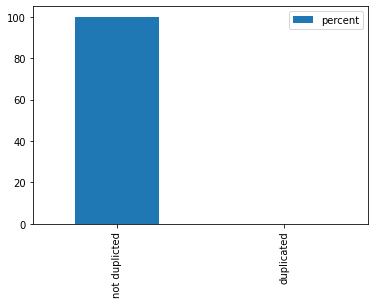

In [ ]:
dup.plot.bar()
plt.show()

## d. 변수 간 상관관계

모든 상관계수가 0.06미만으로 눈에 띄는 상관관계가 존재하지 않는다.

In [ ]:
cor = train.drop('target',axis = 1).corr()
cor

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,...,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,magic
V0,1.000000,0.009006,0.002420,-0.008888,0.002685,-0.011229,0.001148,0.001988,-0.002588,0.005722,0.001679,0.000312,0.000378,0.019541,0.002154,-0.014525,-0.006569,-0.003350,-0.006676,0.012825,0.000159,-0.008542,-0.005479,-0.000933,0.001590,-0.002307,0.005900,-0.006959,0.001326,0.012975,-0.001955,0.001474,-0.002207,-0.003420,0.007712,0.001619,-0.003181,0.001206,-0.006123,0.003203,...,-0.001956,0.001471,-0.000634,-0.022731,-0.003163,0.002264,0.004000,-0.003378,-0.004041,-0.003339,-0.007767,0.000149,-0.000706,0.025675,0.019850,-0.015548,0.008744,0.003781,0.001754,-0.011916,0.001276,-0.001671,0.000304,-0.005377,0.003911,-0.011331,0.018419,0.004688,0.003578,0.016689,-0.006904,0.000274,-0.009842,-0.010021,-0.007280,-0.009622,0.001005,-0.012330,0.013498,-0.022541
V1,0.009006,1.000000,0.001551,0.002587,0.008763,-0.007879,-0.002153,0.001295,0.000357,-0.001328,0.001724,0.000891,0.000375,0.000555,-0.005832,0.012854,0.002635,0.002107,0.001656,0.007272,-0.000875,-0.014532,0.019621,-0.007633,-0.008463,-0.001861,-0.003742,-0.001839,0.005102,-0.000608,0.005491,0.003240,0.025565,0.000793,0.023151,0.001009,-0.001325,0.000167,-0.000819,0.000761,...,0.009085,-0.003770,-0.000922,0.003789,-0.004116,0.007189,0.004309,-0.001655,-0.000294,0.006508,0.001281,0.001373,-0.000069,0.003304,-0.015213,-0.001349,0.003279,0.003767,0.000064,0.008431,-0.012886,-0.012255,-0.005684,0.004493,0.019451,0.002069,0.010082,-0.001531,-0.000475,-0.012981,-0.004801,-0.004291,-0.000678,-0.002501,-0.008291,-0.000729,0.000897,-0.003279,0.003449,-0.008503
V2,0.002420,0.001551,1.000000,-0.005602,-0.003592,-0.000145,0.006182,0.002380,-0.006035,-0.008073,-0.003203,0.018431,0.006401,0.001569,-0.005687,-0.011457,-0.002873,-0.001526,0.009077,0.000267,0.002725,-0.002104,0.012480,0.017807,0.003257,0.001634,0.018850,-0.000751,-0.012293,-0.000132,0.005185,0.003176,0.001313,0.002140,-0.007126,-0.014690,0.000469,0.008285,-0.001682,-0.005360,...,-0.004423,0.007654,-0.001072,-0.005946,0.014644,-0.008648,0.001088,0.003153,-0.003019,-0.003585,0.016319,-0.012896,-0.007003,-0.009793,-0.009234,-0.007247,-0.002513,-0.007425,0.017729,0.004076,-0.003999,-0.004440,-0.032043,-0.005723,-0.001472,0.009071,0.009615,0.006875,-0.011284,-0.005005,-0.001685,-0.000861,-0.004234,-0.001992,-0.012420,0.000820,-0.021197,0.025817,0.012399,0.005110
V3,-0.008888,0.002587,-0.005602,1.000000,0.011979,-0.013491,-0.001169,0.007895,-0.001956,0.005154,-0.016974,-0.004632,0.000764,0.000263,-0.011530,-0.006826,-0.014687,0.007986,0.017631,-0.000273,-0.000015,0.000825,0.008766,0.002508,0.003052,0.000113,-0.002487,-0.000425,0.000755,-0.003107,0.001986,-0.002187,-0.006504,-0.003844,-0.001910,-0.000223,-0.004939,-0.004155,0.002077,0.004355,...,-0.006148,-0.023409,-0.005551,-0.006291,-0.003188,0.005426,0.001846,-0.000633,-0.029766,0.004354,0.003559,-0.007708,0.004017,0.000633,0.010733,-0.001455,-0.002651,-0.003026,-0.007844,0.023654,0.000643,0.007742,0.008237,0.008007,0.004809,0.002088,-0.019601,-0.010247,-0.000190,-0.001628,0.017877,-0.001115,0.008103,-0.008513,-0.006116,0.013554,-0.000110,0.010325,0.006241,0.002532
V4,0.002685,0.008763,-0.003592,0.011979,1.000000,-0.000070,-0.003905,-0.000481,0.000708,0.006572,-0.000579,0.003747,0.010328,0.000742,0.012316,-0.002952,0.000181,-0.000555,-0.000706,0.001364,-0.004765,0.001167,-0.020501,-0.000039,0.002742,0.005931,0.000599,-0.006133,-0.003344,0.002479,-0.003220,-0.000958,-0.010773,-0.026722,-0.003604,-0.006429,-0.001957,0.008090,-0.001999,0.002915,...,0.005401,0.001131,-0.008851,-0.003771,0.002331,0.035891,0.001854,0.003308,0.001005,0.004835,-0.000184,0.006266,0.003830,-0.003582,0.000837,-0.000432,0.000923,-0.000262,0.022750,-0.027649,0

In [ ]:
(cor>=0.06).sum().nunique()

1

## 상관계수 plot 시각화

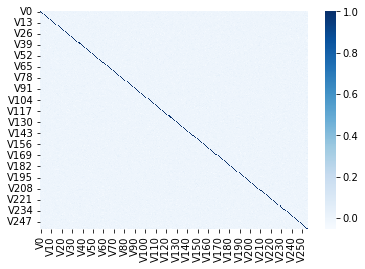

In [ ]:
sns.heatmap(cor, annot = False,
            cmap = "Blues")

## e. 다중공선성 진단

### VIF 지수

분산팽창계수(VIF, Variance Inflation Factor)를 구하여 판단
엄밀한 기준은 없으나 보통 10보다 크면 다중공선성이 있다고 판단한다.

모든 독립변수의 VIF는 1 근방에 위치하기 때문에 다중공선성이 존재하지 않는다.

In [ ]:
model=ols('target~'+"+".join(train.drop('target',axis = 1).columns),train)
res=model.fit()
res.summary()

vif=pd.DataFrame({'변수': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.
vif

,변수,VIF
0,V0,1.020381
1,V1,1.014248
2,V2,1.026818
3,V3,1.018258
4,V4,1.017921
...,...,...
251,V251,1.024010
252,V252,1.025649
253,V253,1.024249
254,V254,1.027154


## VIF 분포 시각화

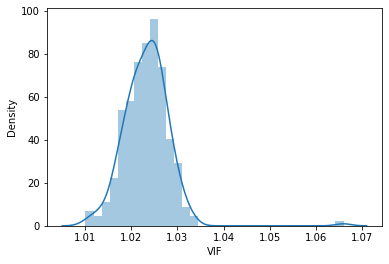

In [ ]:
sns.distplot(vif['VIF'])

## f. 변수 분포

변수의 분포를 파악해서 데이터의 경향성을 확인하고, 이상치 확인 및 정규화의 필요성 등을 점검할 수 있다.

V1~V255까지 변수는 모두 0을 중심으로 대칭적인 분포인 반면, magic 변수는 다른 변수들과 이질적인 패턴인 균일분포와 유사한 분포이다. 

따라서 변수 선택 과정에서 magic 변수를 점검할 필요가 있다고 판단했다.



In [ ]:
for i in range(0, 256):
  data= train.iloc[: ,i]
  sns.distplot(data)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## magic 변수 분포

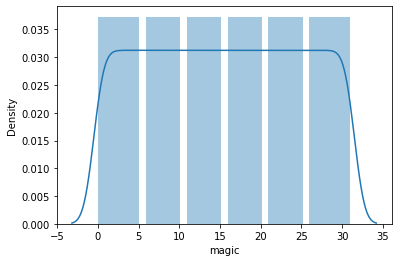

In [ ]:
sns.distplot(train['magic'])

## g. 정규성 검정

### (1) QQ Plot

In [ ]:
## QQ PLOT을 이용한 정규성 검정

for i in range(0, 256):
  data = train.iloc[:, i]

  fig = plt.figure(figsize=(20,5))
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)

  stats.probplot(data, dist=stats.norm, plot=ax1) # 왼쪽에 data와 정규분포를 비교할 수 있는 QQ plot 그림

  mu = data.mean()
  variance = data.var()
  sigma = variance ** 0.5
  ## 검정하고자 하는 데이터의 평균 분산 표준편차 정의

  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100) ## 평균으로부터 3 표준편차만큼 떨어진 구간에서 그래프를 그릴 예정
  ax2.plot(x, stats.norm.pdf(x, mu, sigma), color = "blue" , label = "theoretical") ## 오른쪽에 파란색으로 검정하고자 하는 데이터의 평균, 분산을 갖는 정규분포 그래프 그림

  sns.distplot(ax=ax2, a=data, bins=100, color="red", label="observed") ## 오른쪽에 빨간색으로 검정하고자 하는 데이터의 분포 그림
  ax2.legend() ## 파란색은 이론적 정규분포, 빨간색은 관측값(오른쪽 그래프의 경우)

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

관측 결과, magic을 제외한 모든 변수(V0 - V254)는 그들의 평균과 분산을 가지는 정규분포와 유사한 모양을 띄고 있다.

하지만 대부분의 관측값이 실제 정규분포보다 뾰족한 모양을 띄고 있다. 

그래서 주관이 들어간 QQ PLOT 이 아닌 다른 방법으로 정규성을 검정해보고자 한다.

### (2) Anderson-Darling Test

In [ ]:
## Anderson-Darling Test로 정규성 검정
for i in range(0, 256):
  data = train.iloc[:, i]

  result = anderson(data) ## 해당 변수에 대한 테스트 결과를 result에 저장
  print('variable = V %f'%(i))
  print('stat = %.3f'%(result.statistic)) ## 해당 테스트 결과의 statistics 값 출력
  for j in range(len(result.critical_values)):
    sig_lev, crit_val = result.significance_level[j], result.critical_values[j]
    if (result.statistic < crit_val):
      print(f'Probably Gaussian : {crit_val} critical value at {sig_lev} level of significance')
    else :
      print(f'Probably NOT Gaussian : {crit_val} critcal value at {sig_lev} level of significance')
  ## for loop을 통해 각 critical value에 대해 stat과 대소 비교 후 정규분포 여부 판별

variable = V 0.000000
stat = 1198.847
Probably NOT Gaussian : 0.576 critcal value at 15.0 level of significance
Probably NOT Gaussian : 0.656 critcal value at 10.0 level of significance
Probably NOT Gaussian : 0.787 critcal value at 5.0 level of significance
Probably NOT Gaussian : 0.918 critcal value at 2.5 level of significance
Probably NOT Gaussian : 1.092 critcal value at 1.0 level of significance
variable = V 1.000000
stat = 628.559
Probably NOT Gaussian : 0.576 critcal value at 15.0 level of significance
Probably NOT Gaussian : 0.656 critcal value at 10.0 level of significance
Probably NOT Gaussian : 0.787 critcal value at 5.0 level of significance
Probably NOT Gaussian : 0.918 critcal value at 2.5 level of significance
Probably NOT Gaussian : 1.092 critcal value at 1.0 level of significance
variable = V 2.000000
stat = 1405.085
Probably NOT Gaussian : 0.576 critcal value at 15.0 level of significance
Probably NOT Gaussian : 0.656 critcal value at 10.0 level of significance
Proba

QQ PLOT에서의 그림과 Anderson-Darling Test 결과에 의하면 정규분포를 따르지 않는 것으로 판단된다.

QQ PLOT에서 꼬리 부분(상대적으로 아주 작은 값을 가지거나 아주 큰 값을 가지는 부분)에서 정규분포의 그래프와 크게 벗어나는 것으로 보아 

이상치가 있거나 극단적인 상황에서는 정규분포를 따르지 않는 데이터가 존재하는 것 같다



# 3. 전처리

## a. 스케일링


KNN 모델 사용시 거리 계산을 위해서 train 데이터를 스케일링하였습니다.

Z-score 표준화: 평균을 0, 표준편차 1로 변환

In [ ]:
scaler = StandardScaler() 
scaler.fit(X_train) 
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)